In [1]:
import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset
from torchvision.io import read_image
from typing_extensions import Self
from itertools import permutations
import random
from PIL import Image

In [2]:
shape_dict = {
    0: ['구', '동그라미'],
    1: ['원기둥', '동그란기둥'],
    2: ['육면체', '사각형', '상자'],
    3: ['도넛'],
    4: ['콘', '원뿔']
}

In [3]:
color_dict = {
    'red': ['빨간', '빨강색', '빨강', '붉은'],
    'blue': ['파랑', '파란색', '파란'],
    'green': ['초록', '초록색', '녹색'],
    'yellow': ['노란', '노랑색', '노랑'],
    'black': ['검정', '검은색']
}

In [4]:
train_path = pathlib.Path('.').absolute()
train_path = train_path.joinpath('data', 'train')
train_all_path = train_path.joinpath('scene.all.xlsx')
train_img_dir = train_path.joinpath('images')

In [5]:
train_scene_all = pd.read_excel(train_all_path)
print(train_scene_all.head())

   Unnamed: 0  id                                              scene  \
0           0   0  [('blue', (1, (2, 1, 1))), ('yellow', (2, (2, ...   
1           1   1  [('red', (1, (1, 2, 1))), ('red', (3, (1, 0, 1...   
2           2   2  [('green', (1, (1, 1, 0))), ('red', (1, (0, 1,...   
3           3   3  [('blue', (2, (1, 0, 0))), ('black', (4, (0, 0...   
4           4   4  [('black', (1, (1, 1, 0))), ('red', (2, (0, 2,...   

                                               graph  \
0   [((1, 'blue'), (2, 'yellow'), ('Sx', 'F', 'T'))]   
1  [((1, 'red'), (3, 'red'), ('Sx', 'F', 'Sz')), ...   
2  [((1, 'green'), (1, 'red'), ('R', 'Sy', 'U')),...   
3    [((2, 'blue'), (4, 'black'), ('R', 'Sy', 'U'))]   
4      [((1, 'black'), (2, 'red'), ('R', 'B', 'U'))]   

                                                text  \
0                      파란 동그란기둥은/는 노랑 사각형의 위쪽 앞에 있다.   
1  붉은 동그란기둥은/는 붉은 도넛의 바로 앞에 있다.; 빨강 도넛은/는 빨강 콘의 바...   
2  녹색 원기둥은/는 빨강색 동그란기둥의 오른쪽 아래에 있다.; 붉은 원기둥은/는 빨강...   
3     

In [6]:
print(len(train_scene_all))
train_scene_all.loc[0]

7000


Unnamed: 0                                                    0
id                                                            0
scene         [('blue', (1, (2, 1, 1))), ('yellow', (2, (2, ...
graph          [((1, 'blue'), (2, 'yellow'), ('Sx', 'F', 'T'))]
text                              파란 동그란기둥은/는 노랑 사각형의 위쪽 앞에 있다.
image_fn                              ./data/train/images\0.jpg
Name: 0, dtype: object

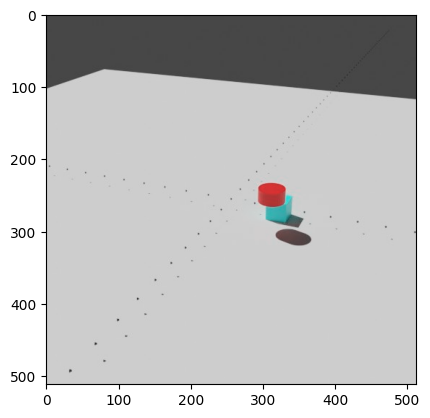

In [7]:
img = cv2.imread(str(train_img_dir.joinpath('0.jpg')))
plt.imshow(img)

In [8]:
class ImageData:
    def __init__(self, img_dir: pathlib.Path):
        assert img_dir.is_absolute()
        self.img_dir = img_dir
    
    def __len__(self):
        length = 0
        for f in self.img_dir.iterdir():
            if f.name.endswith('.jpg'):
                length += 1
        return length
    
    def __getitem__(self, index):
        filename = str(index) + '.jpg'

        path = self.img_dir.joinpath(filename)
        img = Image.open(path)

        return path, img

In [9]:
class SceneData:
    def __init__(self, scenes: pd.Series):
        self.scenes = scenes
    
    def __len__(self):
        return len(self.scenes)
    
    def __getitem__(self, index):
        scene_string = self.scenes[index]
        scene = eval(scene_string)
        return scene

In [10]:
class GraphData:
    def __init__(self, graphs: pd.Series):
        self.graphs = graphs
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, index):
        graph_string = self.graphs[index]
        graph = eval(graph_string)
        return graph

In [11]:
class Object:
    def __init__(self, target):
        self.color = target[0]
        if type(target[1]) is tuple:
            self.shape_id = target[1][0]
            self.position = target[1][1]
        else:
            self.shape_id = target[1]
            self.position = None
    def getX(self):
        return self.position[0] if self.position is not None else None
    def getY(self):
        return self.position[1] if self.position is not None else None
    def getZ(self):
        return self.position[2] if self.position is not None else None
    def get_shape_color(self):
        return (self.shape_id, self.color)
    
    def get_relation(self, target: Self):
        relation = [None, None, None]
        if self.getX() > target.getX():
            relation[0] = 'R'
        elif self.getX() == target.getX():
            relation[0] = 'Sx'
        else:
            relation[0] = 'L'

        if self.getY() > target.getY():
            relation[1] = 'F'
        elif self.getY() == target.getY():
            relation[1] = 'Sy'
        else:
            relation[1] = 'B'

        if self.getZ() > target.getZ():
            relation[2] = 'T'
        elif self.getZ() == target.getZ():
            relation[2] = 'Sz'
        else:
            relation[2] = 'U'

        return tuple(relation)

In [12]:
class Scene:
    shape_dict = {
        0: ['구', '동그라미'],
        1: ['원기둥', '동그란기둥'],
        2: ['육면체', '사각형', '상자'],
        3: ['도넛'],
        4: ['콘', '원뿔']
    }

    color_dict = {
        'red': ['빨간', '빨강색', '빨강', '붉은'],
        'blue': ['파랑', '파란색', '파란'],
        'green': ['초록', '초록색', '녹색'],
        'yellow': ['노란', '노랑색', '노랑'],
        'black': ['검정', '검은색']
    }

    def __init__(self, id, scene, img_path):
        self.id = id
        self.scene_objects = [Object(o) for o in scene]
        self.img_path = img_path
    
    def relation_to_text(self, rel):
        same_count = 0
        for i in rel:
            if 'S' in i:
                same_count += 1

        text = []

        if rel[0] == 'L':
            text.append('왼쪽')
        elif rel[0] == 'R':
            text.append('오른쪽')
        
        if rel[2] == 'T' and rel[1] == 'Sy':
            text.append('위')
        elif rel[2] == 'T':
            text.append('위쪽')
        elif rel[2] == 'U' and rel[0] == 'Sx' and rel[1] != 'Sy':
            text.append('아래쪽')
        elif rel[2] == 'U' and rel[0] == 'Sx' and rel[1] == 'Sy':
            text.append('밑')
        elif rel[2] == 'U':
            text.append('아래')

        if rel[1] == 'F':
            text.append('앞')
        elif rel[1] == 'B':
            text.append('뒤')

        text = ' '.join(text)
            
        if same_count == 2:
            text = '바로 ' + text
        if same_count == 3:
            raise Exception('something wrong!!!!!')
        
        return text
    
    def to_graph(self):
        graph = []

        node_count = (len(self.scene_objects) * (len(self.scene_objects)-1))//2

        for i in range(node_count):
            first = self.scene_objects[i]
            second = self.scene_objects[(i+1)%len(self.scene_objects)]
            node = [None, None, None]
            node[0] = first.get_shape_color()
            node[1] = second.get_shape_color()
            node[2] = first.get_relation(second)

            graph.append(tuple(node))

        return graph
    
    def generate_text(self):
        scene_graph = self.to_graph()
        sentences = [[] for _ in range(len(scene_graph))]
        for i in range(len(scene_graph)):
            item = scene_graph[i]
            first = item[0]
            second = item[1]
            relation = item[2]
            
            for first_shape in Scene.shape_dict[first[0]]:
                for first_color in Scene.color_dict[first[1]]:
                    for second_shape in Scene.shape_dict[second[0]]:
                        for second_color in Scene.color_dict[second[1]]:
                            sentence = [first_color, first_shape+'은/는', second_color, second_shape+'의', self.relation_to_text(relation)+'에', '있다.']
                            sentence = ' '.join(sentence)
                            sentences[i].append(sentence)
        return sentences

In [13]:
scene_data = SceneData(train_scene_all['scene'])

In [14]:
scene_data = SceneData(train_scene_all['scene'])
index = 2
print(len(scene_data))
print(scene_data[index])
print(list(permutations(scene_data[index], len(scene_data[index]))))
print(len(Scene(index, scene_data[index], 'd').generate_text()[2]))

7000
[('green', (1, (1, 1, 0))), ('red', (1, (0, 1, 2))), ('red', (2, (0, 2, 0)))]
[(('green', (1, (1, 1, 0))), ('red', (1, (0, 1, 2))), ('red', (2, (0, 2, 0)))), (('green', (1, (1, 1, 0))), ('red', (2, (0, 2, 0))), ('red', (1, (0, 1, 2)))), (('red', (1, (0, 1, 2))), ('green', (1, (1, 1, 0))), ('red', (2, (0, 2, 0)))), (('red', (1, (0, 1, 2))), ('red', (2, (0, 2, 0))), ('green', (1, (1, 1, 0)))), (('red', (2, (0, 2, 0))), ('green', (1, (1, 1, 0))), ('red', (1, (0, 1, 2)))), (('red', (2, (0, 2, 0))), ('red', (1, (0, 1, 2))), ('green', (1, (1, 1, 0))))]
72


In [15]:
# 내가 생성한 텍스트가 유효한지 확인
shit = []
for i in range(len(train_scene_all))[2000:3000]:
    print(i)
    row = train_scene_all.loc[i]
    text_candidate = Scene(i, scene_data[i], row['image_fn']).generate_text()
    all_texts = []
    if len(text_candidate) == 1:
        for first_sentence in text_candidate[0]:
            all_texts.append(first_sentence)
    elif len(text_candidate) == 2:
        for first_sentence in text_candidate[0]:
            for second_sentence in text_candidate[1]:
                all_texts.append(first_sentence + '; ' + second_sentence)
    elif len(text_candidate) == 3:
        for first_sentence in text_candidate[0]:
            for second_sentence in text_candidate[1]:
                for third_sentence in text_candidate[2]:
                    all_texts.append(first_sentence + '; ' + second_sentence + '; ' + third_sentence)
    
    if row['text'] not in all_texts:
        shit.append((i, row['text'], all_texts))
    
    del all_texts
    del text_candidate

2000
2001
2002
2003
2004
2005
2006


2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206


In [16]:
len(shit)

0

In [17]:
# 유효한 텍스트 중 2배, 3배로 증강하여 저장
scene_all = []
index = 0
mult = 5

In [18]:
for i in range(len(train_scene_all))[:2000]:
    row = train_scene_all.loc[i]
    text_candidate = Scene(i, scene_data[i], row['image_fn']).generate_text()
    all_texts = []
    if len(text_candidate) == 1:
        for first_sentence in text_candidate[0]:
            all_texts.append(first_sentence)
    elif len(text_candidate) == 2:
        for first_sentence in text_candidate[0]:
            for second_sentence in text_candidate[1]:
                all_texts.append(first_sentence + '; ' + second_sentence)
    elif len(text_candidate) == 3:
        for first_sentence in text_candidate[0]:
            for second_sentence in text_candidate[1]:
                for third_sentence in text_candidate[2]:
                    all_texts.append(first_sentence + '; ' + second_sentence + '; ' + third_sentence)
    
    if row['text'] not in all_texts:
        shit.append((i, row['text'], all_texts))
    
    can = [row['text']]
    scene_all.append((row['id'], row['scene'], row['text'], row['image_fn']))
    while len(can) < mult:
        gen_text = random.choice(all_texts)
        if gen_text not in can:
            scene_all.append((row['id'], row['scene'], gen_text, row['image_fn']))
            can.append(gen_text)

    del all_texts
    del text_candidate

In [19]:
for i in range(len(train_scene_all))[2000:4000]:
    row = train_scene_all.loc[i]
    text_candidate = Scene(i, scene_data[i], row['image_fn']).generate_text()
    all_texts = []
    if len(text_candidate) == 1:
        for first_sentence in text_candidate[0]:
            all_texts.append(first_sentence)
    elif len(text_candidate) == 2:
        for first_sentence in text_candidate[0]:
            for second_sentence in text_candidate[1]:
                all_texts.append(first_sentence + '; ' + second_sentence)
    elif len(text_candidate) == 3:
        for first_sentence in text_candidate[0]:
            for second_sentence in text_candidate[1]:
                for third_sentence in text_candidate[2]:
                    all_texts.append(first_sentence + '; ' + second_sentence + '; ' + third_sentence)
    
    if row['text'] not in all_texts:
        shit.append((i, row['text'], all_texts))
    
    can = [row['text']]
    scene_all.append((row['id'], row['scene'], row['text'], row['image_fn']))
    while len(can) < mult:
        gen_text = random.choice(all_texts)
        if gen_text not in can:
            scene_all.append((row['id'], row['scene'], gen_text, row['image_fn']))
            can.append(gen_text)

    del all_texts
    del text_candidate

In [20]:
for i in range(len(train_scene_all))[4000:6000]:
    row = train_scene_all.loc[i]
    text_candidate = Scene(i, scene_data[i], row['image_fn']).generate_text()
    all_texts = []
    if len(text_candidate) == 1:
        for first_sentence in text_candidate[0]:
            all_texts.append(first_sentence)
    elif len(text_candidate) == 2:
        for first_sentence in text_candidate[0]:
            for second_sentence in text_candidate[1]:
                all_texts.append(first_sentence + '; ' + second_sentence)
    elif len(text_candidate) == 3:
        for first_sentence in text_candidate[0]:
            for second_sentence in text_candidate[1]:
                for third_sentence in text_candidate[2]:
                    all_texts.append(first_sentence + '; ' + second_sentence + '; ' + third_sentence)
    
    if row['text'] not in all_texts:
        shit.append((i, row['text'], all_texts))
    
    can = [row['text']]
    scene_all.append((row['id'], row['scene'], row['text'], row['image_fn']))
    while len(can) < mult:
        gen_text = random.choice(all_texts)
        if gen_text not in can:
            scene_all.append((row['id'], row['scene'], gen_text, row['image_fn']))
            can.append(gen_text)

    del all_texts
    del text_candidate

In [21]:
for i in range(len(train_scene_all))[6000:7000]:
    row = train_scene_all.loc[i]
    text_candidate = Scene(i, scene_data[i], row['image_fn']).generate_text()
    all_texts = []
    if len(text_candidate) == 1:
        for first_sentence in text_candidate[0]:
            all_texts.append(first_sentence)
    elif len(text_candidate) == 2:
        for first_sentence in text_candidate[0]:
            for second_sentence in text_candidate[1]:
                all_texts.append(first_sentence + '; ' + second_sentence)
    elif len(text_candidate) == 3:
        for first_sentence in text_candidate[0]:
            for second_sentence in text_candidate[1]:
                for third_sentence in text_candidate[2]:
                    all_texts.append(first_sentence + '; ' + second_sentence + '; ' + third_sentence)
    
    if row['text'] not in all_texts:
        shit.append((i, row['text'], all_texts))
    
    can = [row['text']]
    scene_all.append((row['id'], row['scene'], row['text'], row['image_fn']))
    while len(can) < mult:
        gen_text = random.choice(all_texts)
        if gen_text not in can:
            scene_all.append((row['id'], row['scene'], gen_text, row['image_fn']))
            can.append(gen_text)

    del all_texts
    del text_candidate

In [22]:
len(scene_all)

35000

In [23]:
df = pd.DataFrame(scene_all, columns=['id','scene','text','image_fn'])
df.to_excel('output.xlsx', sheet_name='Sheet1')

In [58]:
a = Object(scene_data[0][0])
b = Object(scene_data[0][1])
print(a.get_relation(b))

('Sx', 'F', 'T')


In [154]:
graph_data = GraphData(train_scene_all['graph'])
print(len(graph_data))
print(graph_data[0])

7000
[((1, 'blue'), (2, 'yellow'), ('Sx', 'F', 'T'))]


In [155]:
relation = {}
find = {
    'true': 0,
    'false': []
}
for i in range(len(graph_data)):
    for a in graph_data[i]:
        check = False
        for b in a[2]:
            if b in relation.keys():
                relation[b] += 1
            else:
                relation[b] = 1
            
            if 'S' in b:
                check = True
        if check:
            find['true'] += 1
        else:
            find['false'].append(i)

print(relation)
print(find)

{'Sx': 4310, 'F': 4830, 'T': 4825, 'Sz': 4382, 'B': 4852, 'R': 4871, 'Sy': 4340, 'U': 4815, 'L': 4841}
{'true': 9749, 'false': [4, 8, 10, 15, 17, 18, 19, 19, 21, 22, 23, 24, 25, 27, 28, 28, 32, 34, 34, 35, 36, 37, 37, 44, 44, 45, 45, 47, 49, 52, 54, 55, 56, 56, 58, 59, 61, 62, 62, 63, 64, 67, 68, 69, 69, 71, 73, 79, 83, 84, 85, 85, 86, 88, 89, 89, 90, 90, 91, 93, 94, 96, 97, 99, 101, 102, 103, 104, 105, 107, 107, 111, 112, 114, 114, 115, 120, 123, 123, 124, 131, 135, 137, 139, 141, 144, 145, 146, 147, 147, 148, 151, 154, 155, 158, 158, 160, 162, 163, 163, 167, 168, 168, 170, 175, 177, 178, 180, 180, 182, 184, 184, 185, 188, 188, 189, 189, 191, 192, 194, 195, 201, 206, 206, 207, 212, 213, 214, 215, 216, 217, 217, 218, 218, 222, 225, 226, 226, 227, 227, 228, 229, 232, 236, 243, 254, 254, 257, 257, 258, 258, 260, 261, 263, 264, 266, 267, 271, 273, 274, 276, 277, 281, 284, 284, 289, 291, 293, 293, 297, 298, 299, 300, 301, 303, 305, 306, 308, 310, 310, 315, 318, 320, 322, 324, 324, 331, 333

In [13]:
img_data = ImageData(img_dir=train_img_dir)
print(len(img_data))
print(img_data[0])
plt.imshow(img_data[0][1].permute(1,2,0))

7000
(WindowsPath('c:/Users/singbhang/Desktop/AI_Term/data/train/images/0.jpg'), <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x220E592DE90>)


AttributeError: 'JpegImageFile' object has no attribute 'permute'

7000
(WindowsPath('c:/Users/singbhang/Desktop/AI_Term/data/train/images/0.jpg'), <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x220E9487910>)
256
RGB


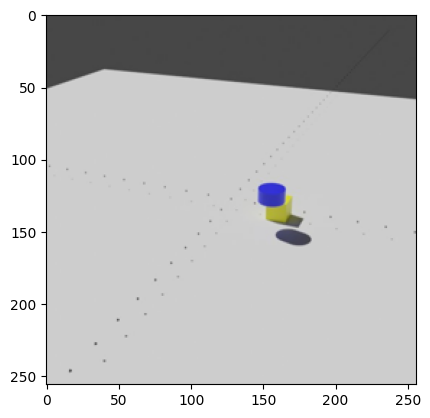

In [16]:
from torchvision.transforms import Resize, InterpolationMode, RandomRotation
img_data = ImageData(img_dir=train_img_dir)
print(len(img_data))
print(img_data[0])
target_size = 256
print(target_size)
resize = Resize((target_size, target_size), interpolation=InterpolationMode.BICUBIC)
print(img_data[0][1].mode)
plt.imshow(resize(img_data[0][1]))

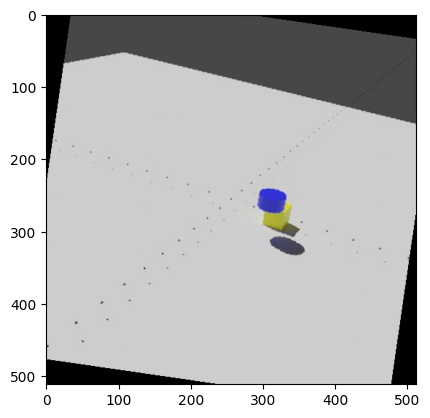

In [20]:
rotation = RandomRotation(degrees=15)
plt.imshow(rotation(img_data[0][1]))

In [23]:
from PIL import Image
from torchvision.transforms import Resize, InterpolationMode, RandomRotation, Compose, ToTensor

In [24]:
def convert_img_to_rgb(image: Image):
    return image.convert("RGB")

def img_transform(size: int, degrees: int):
    return Compose([
        Resize(size, interpolation=InterpolationMode.BICUBIC),
        RandomRotation(degrees=degrees),
        convert_img_to_rgb,
        ToTensor()
    ])

In [34]:
import torch
transform = img_transform(256, 15)
sum = torch.zeros((3,256,256)).type(torch.float64)
for i in range(len(img_data)):
    img = img_data[i][1]
    img = transform(img)
    sum += img.type(torch.float64)

print((sum/7000).mean([1,2]))
print((sum/7000).std([1,2]))

tensor([0.6671, 0.6667, 0.6658], dtype=torch.float64)
tensor([0.2143, 0.2142, 0.2140], dtype=torch.float64)


In [31]:
img = img_data[i][1]
img = transform(img)
print(img.mean([1,2]))
print(img.std([1,2]))

tensor([0.6547, 0.6547, 0.6580])
tensor([0.2688, 0.2688, 0.2665])
